## Многомерная линейная регрессия. Метод главных компонент

**Библиотеки**

In [41]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_regression

from sklearn.decomposition import PCA

from mlxtend.plotting import plot_decision_regions

from torchvision import datasets
from torchvision import transforms

**1. Многомерная линейная регрессия**

**простое решение на основе МНК**

Тривиально получается, что решение задачи
<center>$
\begin{equation}
    \|
        \mathbf{XW} - \mathbf{Y}
    \|_2^2\to
    \min_\mathbf{W}
\end{equation}
$</center>

является матрица:
<center>$
\begin{equation}
    \mathbf{W}^*=\left(
       \mathbf{X}^T\mathbf{X}
    \right)^{-1}\mathbf{X}^T\mathbf{Y}
\end{equation}
$</center>

**Выборка без шума**

In [42]:
np.random.seed(0)
n = 2
l = 100
K = 2
beta = 0.

X = np.random.randn(l, n)
W_true = np.random.randn(n, K)

y = X@W_true + beta*np.random.randn(l, K)

In [43]:
W = np.linalg.inv(X.T@X)@X.T@y

((W - W_true)**2).mean()  # Имеется в виду норма Фробениуса, но просто для
                          # удобства взято среднее

5.854827030937197e-32

**Выборка с шумом**

In [44]:
np.random.seed(0)
betas = np.linspace(0, 10, 1000)
list_of_errors = []

for beta in betas:
    y = X@W_true + beta*np.random.randn(l, K)
    
    W = np.linalg.inv(X.T@X)@X.T@y
    
    list_of_errors.append(((W - W_true)**2).mean())

Зависимость расстояния между истинной матрицей параметров и аппроксимацией от $\beta$:

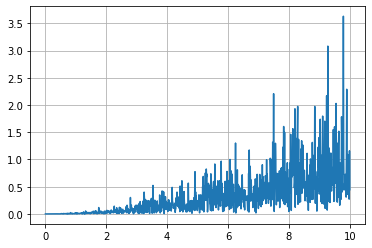

In [45]:
plt.plot(betas, list_of_errors)

plt.grid()
plt.show()

**2. SVD**

SVD-разложение:
<center>$
\begin{equation}
    \mathbf{X}=\mathbf{VDU}^T
\end{equation}
$</center>

Лемма (представление псевдообратной матрицы):
<center>$
\begin{equation}
    \mathbf{X}^+ =
    \left(
        \mathbf{X}^T\mathbf{X}
    \right)^T\mathbf{X}^T =
    \mathbf{UD}^{-1}\mathbf{V}^T
\end{equation}
$</center>

Получаем:
<center>$
\begin{equation}
    \mathbf{W}^*=\mathbf{UD}^{-1}\mathbf{V}^T\mathbf{Y}
\end{equation}
$</center>

In [46]:
np.random.seed(0)
n = 2
l = 100
K = 2
beta = 0.

X = np.random.randn(l, n)
W_true = np.random.randn(n, K)

y = X@W_true + beta*np.random.randn(l, K)

In [47]:
V, d, U = np.linalg.svd(X, full_matrices=False)  # SVD-разложение в NumPy
# full_matrices=False - срезанная матрица;
# если full_matrices=True, то матрица собств. вект. V будет иметь размерность
# (n x n). Но так как матрица X прямоугольная, то часть собств. вект. будет
# лишней, их full_matrices=False и отбрасывает. Соответсвенно, собств. знач.
# упорядочены.

# d - массив диагональных элементов, а не диагональная матрица.
# d - массив из корней собственных значений

D = np.eye(len(d))*d
lambd = d**2

Число обусловленности для матрицы $\mathbf{XX}^T$:

In [48]:
np.max(lambd) / np.min(lambd)

1.049588919547096

Качество аппроксимации:

In [49]:
W = (U.T@np.linalg.inv(D)@V.T)@y

((W - W_true)**2).mean()

5.72001193483009e-32

Посмотрим на результаты изменения $\mu$

In [50]:
np.random.seed(0)
mus = np.linspace(0, 1, 10)
list_of_errors = []

for mu in mus:
    lambd_new = np.array(lambd)
    lambd_new[1] = mu * lambd_new[0]
    d_new = np.sqrt(lambd_new)
    D_new = np.eye(len(d_new))*d_new
    X_new = V@D_new@U
    
    y = X_new@W_true
    
    W = np.linalg.inv(X_new.T@X_new)@X_new.T@y
    
    list_of_errors.append(((W - W_true)**2).mean())

Зависимость качества от $\mu$:

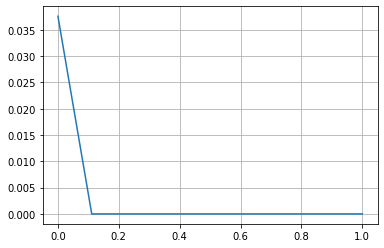

In [51]:
plt.plot(mus, list_of_errors)

plt.grid()
plt.show()

Картинка не самая информативная ввиду маленького количества точек.

Обобщим данный график, рассмотрев зависимость качества аппроксимации $\mathbf{W}$ от $\mu$ и $\beta$:

In [52]:
np.random.seed(0)
mus = np.linspace(0., 1., 100)
betas = np.linspace(0., 2., 100)
list_of_errors = dict()

for beta in betas:
    list_of_errors[str(beta)] = dict()
    for mu in mus:
        lambd_new = np.array(lambd)
        lambd_new[1] = mu * lambd_new[0]
        d_new = np.sqrt(lambd_new)
        D_new = np.eye(len(d_new))*d_new
        X_new = V@D_new@U
    
        y = X_new@W_true + beta*np.random.randn(l, K)

        W = np.linalg.inv(X_new.T@X_new)@X_new.T@y

        list_of_errors[str(beta)][str(mu)] = ((W - W_true)**2).mean()

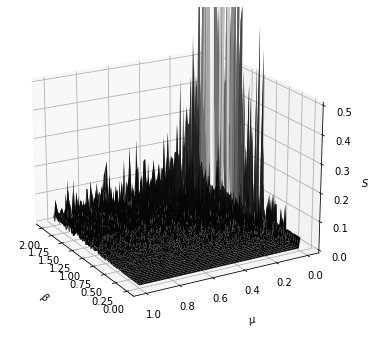

In [53]:
BETAS, MUS = np.meshgrid(betas, mus)
scores = np.zeros_like(BETAS)
for i in range(len(BETAS)):
    for j in range(len(BETAS[i])):
        scores[i][j] = list_of_errors[str(BETAS[i][j])][str(MUS[i][j])]
        
fig = plt.figure(figsize=(14.0, 6.0))
ax = plt.axes(projection='3d')
ax.plot_surface(BETAS, MUS, scores, cmap='gist_gray', alpha=0.99)
ax.set_xlabel(r'$\beta$', labelpad=14), ax.set_ylabel(r'$\mu$', labelpad=14)
ax.set_zlabel(r'$S$'), ax.set_zlim((0, 0.5)), ax.view_init(20, 150)

plt.show()

Посмотрим, как влияют $\mu$ и $\beta$ на качество аппроксимации вектора $\mathbf{Y}$:

In [54]:
np.random.seed(0)
mus = np.linspace(0., 1., 100)
betas = np.linspace(0., 2., 100)
list_of_errors = dict()

for beta in betas:
    list_of_errors[str(beta)] = dict()
    for mu in mus:
        lambd_new = np.array(lambd)
        lambd_new[1] = mu * lambd_new[0]
        d_new = np.sqrt(lambd_new)
        D_new = np.eye(len(d_new))*d_new
        X_new = V@D_new@U
    
        y = X_new@W_true + beta*np.random.randn(l, K)

        W = np.linalg.inv(X_new.T@X_new)@X_new.T@y

        list_of_errors[str(beta)][str(mu)] = ((y - X_new@W)**2).mean()

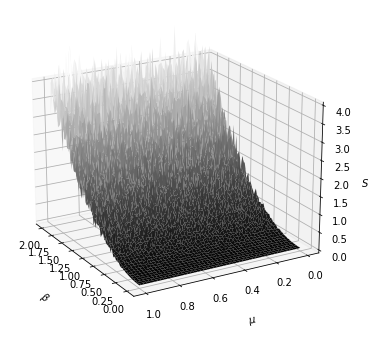

In [55]:
BETAS, MUS = np.meshgrid(betas, mus)
scores = np.zeros_like(BETAS)
for i in range(len(BETAS)):
    for j in range(len(BETAS[i])):
        scores[i][j] = list_of_errors[str(BETAS[i][j])][str(MUS[i][j])]
        
fig = plt.figure(figsize=(14.0, 6.0))
ax = plt.axes(projection='3d')
ax.plot_surface(BETAS, MUS, scores, cmap='gist_gray', alpha=0.99)
ax.set_xlabel(r'$\beta$', labelpad=14), ax.set_ylabel(r'$\mu$', labelpad=14)
ax.set_zlabel(r'$S$'), ax.set_zlim((0, 4)), ax.view_init(20, 150)

plt.show()

Таким образом, от $\mu$ ничего не зависит.

**3. Регуляризация в многомерной регрессии**

Для простоты рассмотрим $L_2$ регуляризацию.

**Простое решение на основе МНК**

Тривиально получается, что решением задачи:
<center>$
\begin{equation}
    \|
        \mathbf{XW} - \mathbf{Y}
    \|_2^2 +
    \tau \|
        \mathbf{W}
    \|_2^2 \to
    \min_\mathbf{W}
\end{equation}
$</center>

является матрица:
<center>$
\begin{equation}
    \mathbf{W}^*=\left(
        \mathbf{X}^T\mathbf{X}+\tau\mathbf{I}
    \right)^{-1}\mathbf{X}^T\mathbf{Y}
\end{equation}
$</center>

$\tau$ $-$ параметр регуляризации:  
$\tau\to\infty\Rightarrow\mathbf{W}\equiv0$;  
$\tau\to0$ регуляризация не действует.

**Решение через SVD**

Лемма:
<center>$
    \mathbf{W}^*=
    \mathbf{UD}\left(
        \mathbf{D}^2 + \tau\mathbf{I}
    \right)^{-1}\mathbf{V}^T
$</center>

In [56]:
np.random.seed(0)
n = 2
l = 100
K = 2

X = np.random.randn(l, n)
W_true = np.random.randn(n, K)

In [57]:
tau = 10.
W = (U.T@D@np.linalg.inv(D**2 + tau*np.eye(len(D)))@V.T)@y

((W - W_true)**2).mean()

0.02285484890175392

Мы немного потеряли в качестве, так как мы находимся не в минимуме функционала, а в некоторой смещенной точке. Но данная потеря более чем допустима.

Рассмотрим зависимость качества аппроксимации $\mathbf{W}$ от $\mu$ и $\beta$:

In [58]:
np.random.seed(0)
mus = np.linspace(0., 1., 100)
betas = np.linspace(0., 2., 100)
tau = 10
list_of_errors = dict()

for beta in betas:
    list_of_errors[str(beta)] = dict()
    for mu in mus:
        lambd_new = np.array(lambd)
        lambd_new[1] = mu * lambd_new[0]
        d_new = np.sqrt(lambd_new)
        D_new = np.eye(len(d_new))*d_new
        X_new = V@D_new@U
    
        y = X_new@W_true + beta*np.random.randn(l, K)

        W = (U.T@D_new@np.linalg.inv(D_new**2 + tau*np.eye(len(D_new)))@V.T)@y

        list_of_errors[str(beta)][str(mu)] = ((W - W_true)**2).mean()

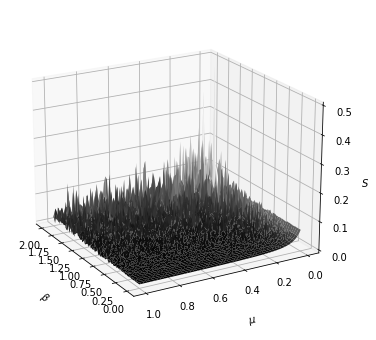

In [59]:
BETAS, MUS = np.meshgrid(betas, mus)
scores = np.zeros_like(BETAS)
for i in range(len(BETAS)):
    for j in range(len(BETAS[i])):
        scores[i][j] = list_of_errors[str(BETAS[i][j])][str(MUS[i][j])]
        
fig = plt.figure(figsize=(14.0, 6.0))
ax = plt.axes(projection='3d')
ax.plot_surface(BETAS, MUS, scores, cmap='gist_gray', alpha=0.99)
ax.set_xlabel(r'$\beta$', labelpad=14), ax.set_ylabel(r'$\mu$', labelpad=14)
ax.set_zlabel(r'$S$'), ax.set_zlim((0, 0.5)), ax.view_init(20, 150)

plt.show()

Зависимость качества аппроксимации вектора $\mathbf{Y}$ от $\mu$ и $\beta$:

In [60]:
np.random.seed(0)
mus = np.linspace(0., 1., 100)
betas = np.linspace(0., 2., 100)
list_of_errors = dict()

for beta in betas:
    list_of_errors[str(beta)] = dict()
    for mu in mus:
        lambd_new = np.array(lambd)
        lambd_new[1] = mu * lambd_new[0]
        d_new = np.sqrt(lambd_new)
        D_new = np.eye(len(d_new))*d_new
        X_new = V@D_new@U
    
        y = X_new@W_true + beta*np.random.randn(l, K)

        W = np.linalg.inv(X_new.T@X_new)@X_new.T@y

        list_of_errors[str(beta)][str(mu)] = ((y - X_new@W)**2).mean()

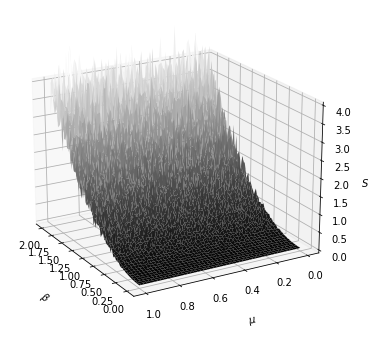

In [61]:
BETAS, MUS = np.meshgrid(betas, mus)
scores = np.zeros_like(BETAS)
for i in range(len(BETAS)):
    for j in range(len(BETAS[i])):
        scores[i][j] = list_of_errors[str(BETAS[i][j])][str(MUS[i][j])]
        
fig = plt.figure(figsize=(14.0, 6.0))
ax = plt.axes(projection='3d')
ax.plot_surface(BETAS, MUS, scores, cmap='gist_gray', alpha=0.99)
ax.set_xlabel(r'$\beta$', labelpad=14), ax.set_ylabel(r'$\mu$', labelpad=14)
ax.set_zlabel(r'$S$'), ax.set_zlim((0, 4)), ax.view_init(20, 150)

plt.show()

$\tau$ всегда необходимо подбирать под данные.


Заметим, что формула решения на основе МНК требует вычисление обратной матрицы от матрицы $\mathbf{X}^T\mathbf{X}$, в то время как формула решения через SVD требует вычисления обратной матрицы лишь от диагональной, что считется очень быстро.

**4. Метод главных компонент**

**4.1. Пример**

Классификация рукописных цифр.

In [63]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True)
X_train = MNIST_train.data.view([-1, 784]).cpu().numpy()
Y_train = MNIST_train.targets.cpu().numpy()

MNIST_test = datasets.MNIST('./mnist', train=False, download=True)
X_test = MNIST_test.data.view([-1, 784]).cpu().numpy()
Y_test = MNIST_test.targets.cpu().numpy()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist\MNIST\raw\train-images-idx3-ubyte.gz to ./mnist\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist\MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist\MNIST\raw



c:\users\ski6a\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [64]:
pca = PCA(2)  # Сингулярное разложение и выбор двух главных компонент
X_train_low = pca.fit_transform(X_train)
X_test_low = pca.fit_transform(X_test)

Визуализация получившегося признакового пространства:

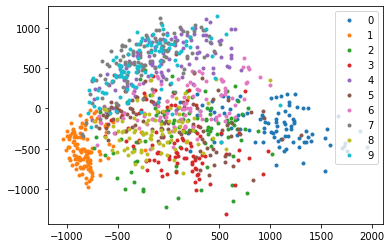

In [65]:
for k in np.unique(Y_train):
    idx = np.where(Y_train[:1000] == k)[0]
    plt.plot(X_train_low[idx, 0], X_train_low[idx, 1], '.', label=str(k))
    
plt.legend(loc='best')
plt.show()

Из рисунка видно, что, можно явно отделить единицы и нули. Остальные цифры перемешаны.

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

c:\users\ski6a\appdata\local\programs\python\python37\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

В качестве нейронной сети воспользуемся моделью персептрона из третьего семинара:

In [76]:
class Perceptron(torch.nn.Module):
    def __init__(self, input_dim=784, num_layers=0,
                 hidden_dim=64, output_dim=10, p=0.0, device='cpu'):

        super(Perceptron, self).__init__()
        
        self.layers = torch.nn.Sequential()
        
        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i+1),
                                   torch.nn.Linear(prev_size, hidden_dim))
            
            self.layers.add_module('relu{}'.format(i+1), torch.nn.ReLU())
            
            self.layers.add_module('dropout{}'.format(i+1), torch.nn.Dropout(p=p))
            
            prev_size = hidden_dim
            
        self.layers.add_module('classifier',
                                torch.nn.Linear(prev_size, output_dim))
        self.to(device)
        
        
    def forward(self, input):
        return self.layers(input)

In [77]:
def trainer(model, dataset, loss_function, optimizer, epochs):
    for epoch in tqdm(range(epochs), leave=False):
        generator = torch.utils.data.DataLoader(dataset, batch_size=64,
                                                shuffle=True)
        for x,y in tqdm(generator, leave=False):
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)
            
            output = model(x)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

In [78]:
def testing(model, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=64)
    
    pred = []
    real = []
    for x,y in tqdm(generator, leave=False):
        x = x.to(device)
        y = y.to(device)
        
        pred.extend(torch.argmax(model(x), dim=-1).cpu().numpy().tolist())
        real.extend(y.cpu().numpy().tolist())
        
    return np.mean(np.array(real) == np.array(pred)), \
           classification_report(real, pred)

Качество без PCA:

In [79]:
model = Perceptron(device=device)
dataset_train = torch.utils.data.TensorDataset(torch.Tensor(X_train),
                                               torch.LongTensor(Y_train))
dataset_test = torch.utils.data.TensorDataset(torch.Tensor(X_test),
                                              torch.LongTensor(Y_test))

_ = model.train()
trainer(model=model,
        dataset=dataset_train,
        loss_function=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
        epochs=1)

print(testing(model, dataset_test)[1])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       980
           1       0.96      0.96      0.96      1135
           2       0.95      0.76      0.85      1032
           3       0.82      0.85      0.83      1010
           4       0.90      0.91      0.91       982
           5       0.73      0.89      0.80       892
           6       0.92      0.94      0.93       958
           7       0.86      0.94      0.90      1028
           8       0.79      0.82      0.80       974
           9       0.93      0.78      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



accuracy: $88\%$; Увеличив количество эпох до $5$-$7$ можно получить качество порядка $93\%$.

Применим PCA:

In [80]:
pca = PCA(2)
X_train_low = pca.fit_transform(X_train)
X_test_low = pca.transform(X_test)

In [81]:
model = Perceptron(input_dim=2, device=device)
dataset_train = torch.utils.data.TensorDataset(torch.Tensor(X_train_low),
                                               torch.LongTensor(Y_train))
dataset_test = torch.utils.data.TensorDataset(torch.Tensor(X_test_low),
                                              torch.LongTensor(Y_test))

_ = model.train()
trainer(model=model,
        dataset=dataset_train,
        loss_function=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
        epochs=1)

print(testing(model, dataset_test)[1])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.55      0.76      0.64       980
           1       0.65      0.88      0.75      1135
           2       0.20      0.36      0.25      1032
           3       0.27      0.15      0.20      1010
           4       0.28      0.25      0.26       982
           5       0.13      0.04      0.06       892
           6       0.05      0.01      0.02       958
           7       0.32      0.83      0.46      1028
           8       0.32      0.01      0.02       974
           9       0.03      0.02      0.02      1009

    accuracy                           0.34     10000
   macro avg       0.28      0.33      0.27     10000
weighted avg       0.29      0.34      0.28     10000



Качество упало до $34\%$. Откуда $34\%$?

$10\%$ можно получить случайно определяя класс (подбрасывая симметричную монетку с 10-ю сторонами). Из картинке выше, как уже было сказано, классы с нулями и единицами можно легко отделить; два класса по $10\%$ $-$ в сумме $30\%$. Остальные проценты можно подтянуть также взглянув на картинку и увидев, что небольшое количество точек можно также отделить от других, что в результате даст небольшие проценты точной классификации.

Оставим $10$ компонент:

In [82]:
pca = PCA(10)
X_train_low = pca.fit_transform(X_train)
X_test_low = pca.transform(X_test)

In [83]:
model = Perceptron(input_dim=10, device=device)
dataset_train = torch.utils.data.TensorDataset(torch.Tensor(X_train_low),
                                               torch.LongTensor(Y_train))
dataset_test = torch.utils.data.TensorDataset(torch.Tensor(X_test_low),
                                              torch.LongTensor(Y_test))

_ = model.train()
trainer(model=model,
        dataset=dataset_train,
        loss_function=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
        epochs=1)

print(testing(model, dataset_test)[1])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.82      0.91      0.87       980
           1       0.89      0.95      0.92      1135
           2       0.78      0.76      0.77      1032
           3       0.81      0.79      0.80      1010
           4       0.77      0.68      0.72       982
           5       0.73      0.57      0.64       892
           6       0.79      0.83      0.81       958
           7       0.80      0.84      0.82      1028
           8       0.76      0.69      0.72       974
           9       0.65      0.75      0.70      1009

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



В данном случае качество получилось порядка $80\%$. То есть мы сократили признаковое описание в $78,4$ раза и потеряли всего $10\%$ качества.

Оставим $100$ главных компонент:

In [84]:
pca = PCA(100)
X_train_low = pca.fit_transform(X_train)
X_test_low = pca.transform(X_test)

In [85]:
model = Perceptron(input_dim=100, device=device)
dataset_train = torch.utils.data.TensorDataset(torch.Tensor(X_train_low),
                                               torch.LongTensor(Y_train))
dataset_test = torch.utils.data.TensorDataset(torch.Tensor(X_test_low),
                                              torch.LongTensor(Y_test))

_ = model.train()
trainer(model=model,
        dataset=dataset_train,
        loss_function=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
        epochs=1)

print(testing(model, dataset_test)[1])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       980
           1       0.95      0.96      0.95      1135
           2       0.90      0.89      0.89      1032
           3       0.89      0.89      0.89      1010
           4       0.84      0.92      0.88       982
           5       0.86      0.84      0.85       892
           6       0.92      0.92      0.92       958
           7       0.87      0.90      0.89      1028
           8       0.86      0.81      0.84       974
           9       0.87      0.80      0.83      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



В этом случае качество сравнимо с качеством исходной модели. Но в данной модели размерность признакового описания была уменьшена.

**4.2. Применение метода главных компонент для сжатия изображений**

**Черно-белое изображение**

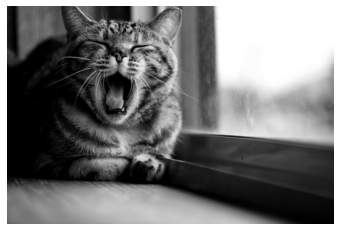

In [87]:
img = imread('img/cat.jpg').mean(axis=-1)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.show()

Сингулярное разложение:

In [88]:
V, d, U = np.linalg.svd(img, full_matrices=False)
D = np.diag(d)

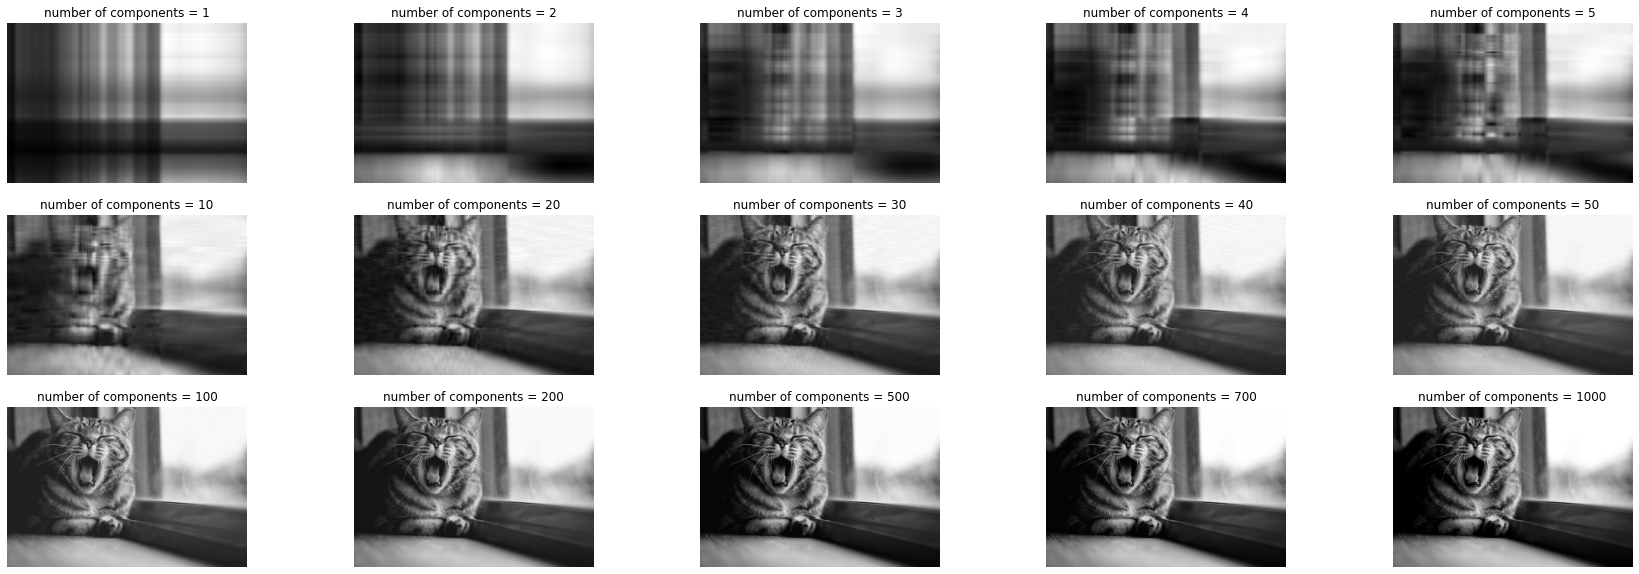

In [93]:
ranks = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 200, 500, 700, 1000]

fig = plt.figure(figsize=(30, 10))
gs = gridspec.GridSpec(3, 5)
ax = np.empty([len(ranks)], dtype=object)
for i in range(len(ranks)):
    ax[i] = fig.add_subplot(gs[i])
    
for i,k in enumerate(ranks):
    img_new = V[:, :k] @ D[:k, :k] @ U[:k, :]  # :k - отбрасывание компонент
    ax[i].imshow(img_new, cmap='gray'), ax[i].axis('off')
    ax[i].set_title('number of components = {}'.format(k))
    
plt.show()

Чем меньше главных компонент, тем больше шума. Таким образом, хороший пример использования сингулярного разложения $-$ расширение обучающей выборки путем добавления сжатых изображений из той же выборки. Обучение по такой выборке сделает модель более устойчивой к шуму.

**Цветное изображение**

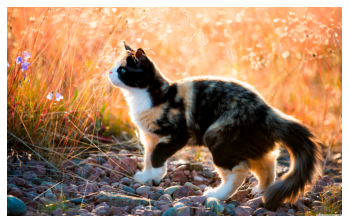

In [102]:
img = imread('img/cat2.jpg')
plt.imshow(img)
plt.axis('off')

plt.show()

Данное изображение состоит из трех матриц (точнее из тензора размерности $3$) $-$ красный, зеленый и голубой каналы (RGB). Самый простой способ сегментации цветного изображения - применим разложения к трем матрицам:

In [104]:
V_1, d, U_1 = np.linalg.svd(img[:, :, 0], full_matrices=False)
D_1 = np.diag(d)

V_2, d, U_2 = np.linalg.svd(img[:, :, 1], full_matrices=False)
D_2 = np.diag(d)

V_3, d, U_3 = np.linalg.svd(img[:, :, 2], full_matrices=False)
D_3 = np.diag(d)

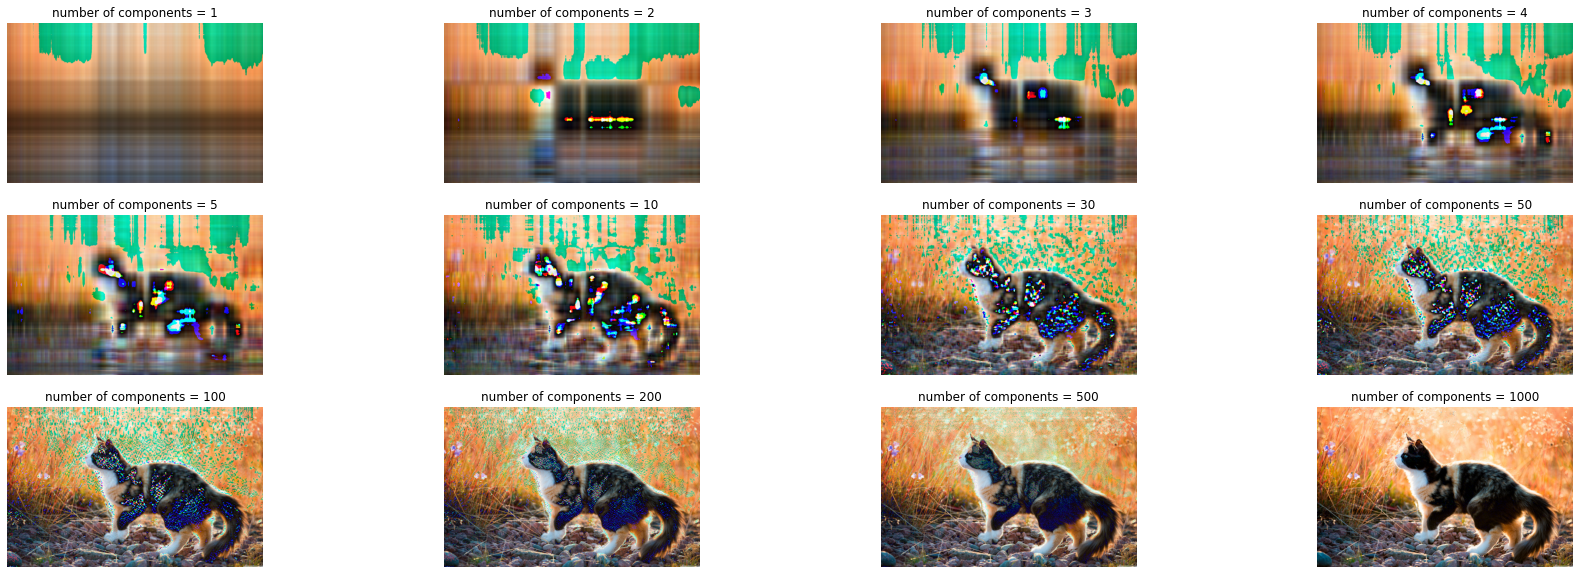

In [106]:
ranks = [1, 2, 3, 4, 5, 10, 30, 50, 100, 200, 500, 1000]

fig = plt.figure(figsize=(30, 10))
gs = gridspec.GridSpec(3, 4)
ax = np.empty([len(ranks)], dtype=object)
for i in range(len(ranks)):
    ax[i] = fig.add_subplot(gs[i])
    
img_new = np.empty_like(img)
for i,k in enumerate(ranks):
    img_new[:, :, 0] = V_1[:, :k] @ D_1[:k, :k] @ U_1[:k, :]
    img_new[:, :, 1] = V_2[:, :k] @ D_2[:k, :k] @ U_2[:k, :]
    img_new[:, :, 2] = V_3[:, :k] @ D_3[:k, :k] @ U_3[:k, :]
    ax[i].imshow(img_new), ax[i].axis('off')
    ax[i].set_title('number of components = {}'.format(k))
    
plt.show()

Так как шумы представляют собой несколько цветных каналов, то при их смешивании шум будет более сильно выражен.